## Importing Libraries

In [61]:
# Import Data Science Libraries
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
print(tf.keras.__version__)

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

3.9.0


## Downloading Helper Functions

import urllib.request

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
urllib.request.urlretrieve(url, "helper_functions.py")

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

## Batch Size & Target Size

In [62]:
BATCH_SIZE = 8
TARGET_SIZE = (224,224)

In [63]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

#### Overview of Dataset

In [64]:
dataset = "dataset"  
walk_through_dir(dataset)

There are 9 directories and 0 images in 'dataset'.
There are 0 directories and 500 images in 'dataset\Acitinic Keratosis'.
There are 0 directories and 500 images in 'dataset\Basal Cell Carcinoma'.
There are 0 directories and 400 images in 'dataset\Dermatofibroma'.
There are 0 directories and 505 images in 'dataset\Melanoma'.
There are 0 directories and 500 images in 'dataset\Nevus'.
There are 0 directories and 500 images in 'dataset\Pigmented Benign Keratosis'.
There are 0 directories and 500 images in 'dataset\Seborrheic Keratosis'.
There are 0 directories and 414 images in 'dataset\Squamous Cell Carcinoma'.
There are 0 directories and 290 images in 'dataset\Vascular Lesion'.


In [65]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [66]:
N=list(range(len(image_df)))
random.shuffle(N)
image_df=image_df.iloc[N].reset_index(drop=True)

display(image_df)

Filepath  \
0     dataset\Pigmented Benign Keratosis\ISIC_003245...   
1              dataset\Vascular Lesion\ISIC_0054532.jpg   
2           dataset\Acitinic Keratosis\ISIC_0060235.jpg   
3         dataset\Seborrheic Keratosis\ISIC_0065003.jpg   
4         dataset\Seborrheic Keratosis\ISIC_5605916.jpg   
...                                                 ...   
4102                     dataset\Nevus\ISIC_5822470.jpg   
4103  dataset\Pigmented Benign Keratosis\ISIC_003521...   
4104                     dataset\Nevus\ISIC_2125566.jpg   
4105  dataset\Pigmented Benign Keratosis\ISIC_003583...   
4106                     dataset\Nevus\ISIC_0774442.jpg   

                           Label  
0     Pigmented Benign Keratosis  
1                Vascular Lesion  
2             Acitinic Keratosis  
3           Seborrheic Keratosis  
4           Seborrheic Keratosis  
...                          ...  
4102                       Nevus  
4103  Pigmented Benign Keratosis  
4104                       Nevus  
4105  Pigmented Benign Keratosis  
4106                       Nevus  

[4107 rows x 2 columns]

Label
Melanoma                      505
Pigmented Benign Keratosis    500
Acitinic Keratosis            500
Basal Cell Carcinoma          500
Seborrheic Keratosis          500
Nevus                         500
Squamous Cell Carcinoma       414
Dermatofibroma                399
Vascular Lesion               289
Name: count, dtype: int64


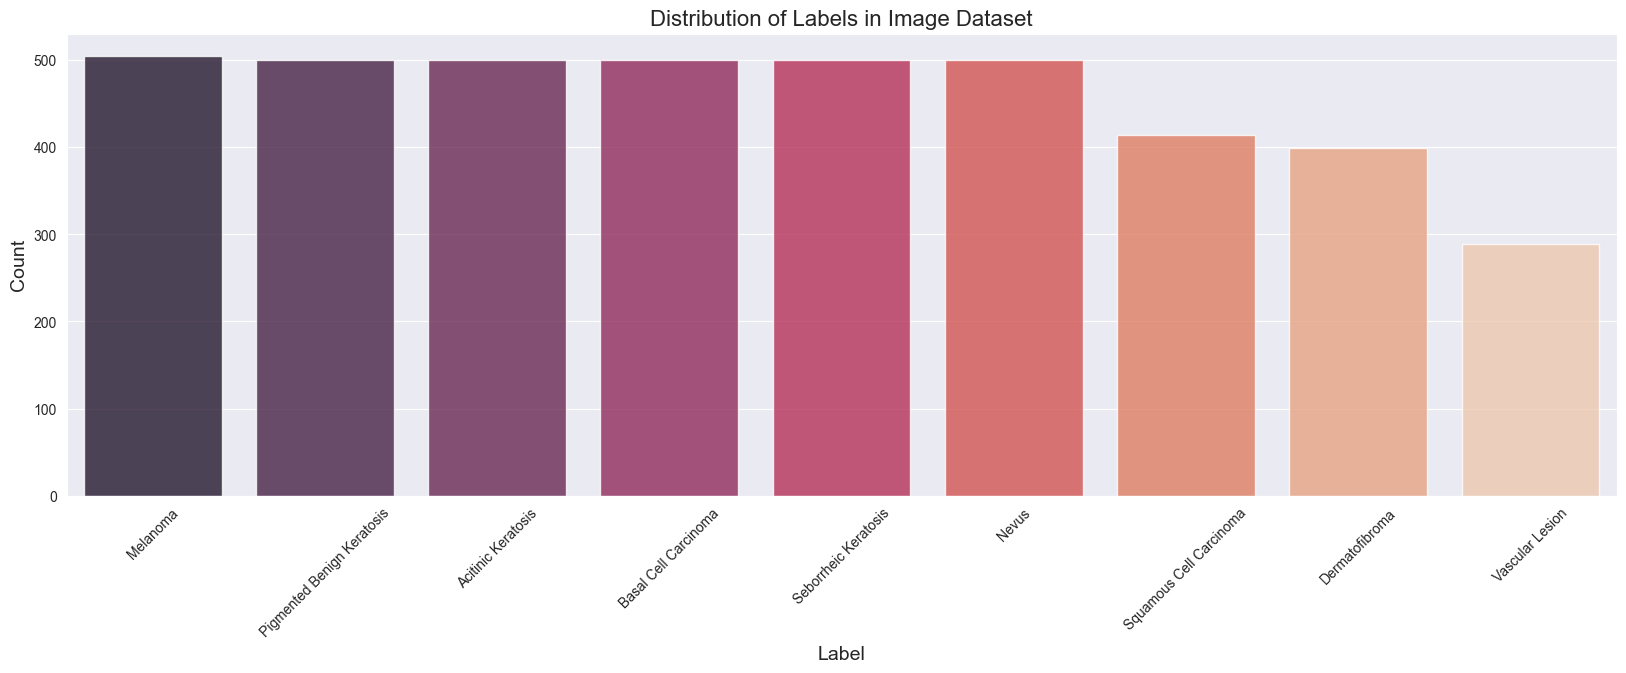

In [67]:
label_counts = image_df['Label'].value_counts()
print(label_counts)

if not label_counts.empty:
    plt.figure(figsize=(20, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket', hue=label_counts.index, legend=False)
    plt.title('Distribution of Labels in Image Dataset', fontsize=16)
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data to display. The 'Label' column is empty.")

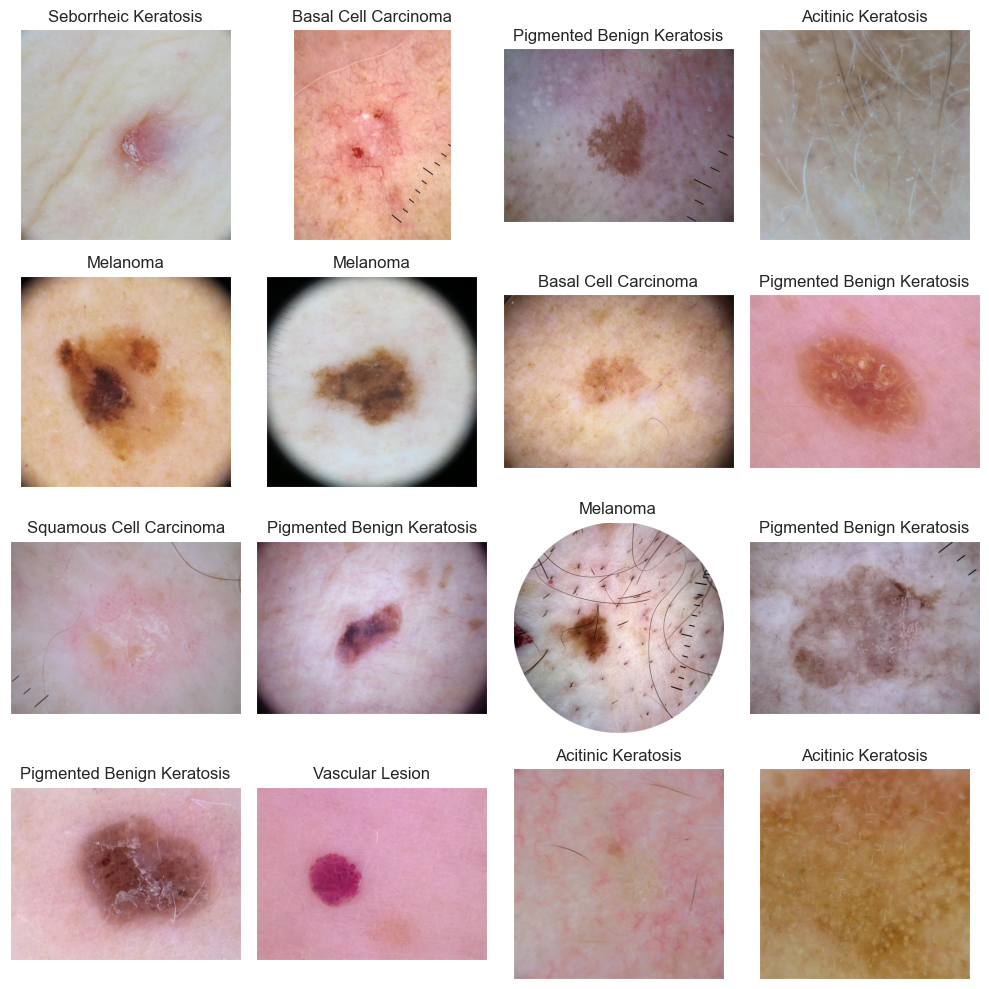

In [68]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Splitting into train and test data

In [69]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [70]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

## Splitting data into 3 categories

In [71]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2628 validated image filenames belonging to 9 classes.
Found 657 validated image filenames belonging to 9 classes.
Found 822 validated image filenames belonging to 9 classes.


In [72]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224,224),
    layers.Rescaling(1./255)
])

# Setup data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")

['Acitinic Keratosis', 'Basal Cell Carcinoma', 'Dermatofibroma', 'Melanoma', 'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis', 'Squamous Cell Carcinoma', 'Vascular Lesion']


In [73]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2

# Load Pretrained MobileNetV3 Model
pretrained_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze more layers for deeper fine-tuning
for layer in pretrained_model.layers[-30:]:  
    layer.trainable = True  

# Checkpoint to Save Best Model
checkpoint_callback = ModelCheckpoint(
    filepath="classification_model_checkpoint.weights.h5",
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,  # More patience for stability
    restore_best_weights=True
)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Data Augmentation Layer (More Transformations)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1),
])

# Define the Model
inputs = pretrained_model.input
x = resize_and_rescale(inputs)  # Preprocessing
x = data_augmentation(x)  # Stronger Augmentation

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Increased Dropout

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output Layer with Label Smoothing
outputs = Dense(len(class_labels), activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=inputs, outputs=outputs)

# Try SGD with Momentum for better generalization
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Smoother Loss
    metrics=['accuracy']
)

# Callbacks List
callbacks = [checkpoint_callback, early_stopping, lr_scheduler]

# Model Summary
# model.summary()


In [74]:
history = model.fit(
    train_images,
    epochs=30,
    validation_data=val_images
)

results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

e:\Deep Learning\Deep_Learning_2024\Skin Disease\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 153s 405ms/step - accuracy: 0.2017 - loss: 3.7315 - val_accuracy: 0.2861 - val_loss: 3.1927
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 127s 386ms/step - accuracy: 0.3450 - loss: 3.1107 - val_accuracy: 0.4277 - val_loss: 2.7963
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 118s 357ms/step - accuracy: 0.4303 - loss: 2.8243 - val_accuracy: 0.4673 - val_loss: 2.7377
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 119s 363ms/step - accuracy: 0.4683 - loss: 2.7143 - val_accuracy: 0.4947 - val_loss: 2.6305
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 126s 383ms/step - accuracy: 0.4942 - loss: 2.6213 - val_accuracy: 0.5403 - val_loss: 2.5705
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 120s 365ms/step - accuracy: 0.5325 - loss: 2.5467 - val_accuracy: 0.5632 - val_loss: 2.5867
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 120s 366ms/step - accuracy: 0.5483 - loss: 2.5121 - val_accuracy: 0.5769 - val_loss: 2.5053
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 118s 359ms/step - accuracy: 0.5872 -

## Visualizing

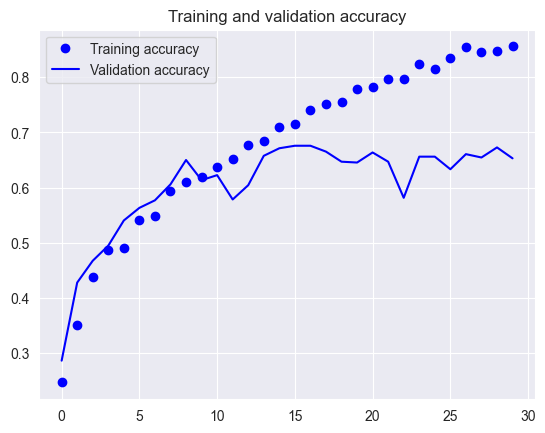

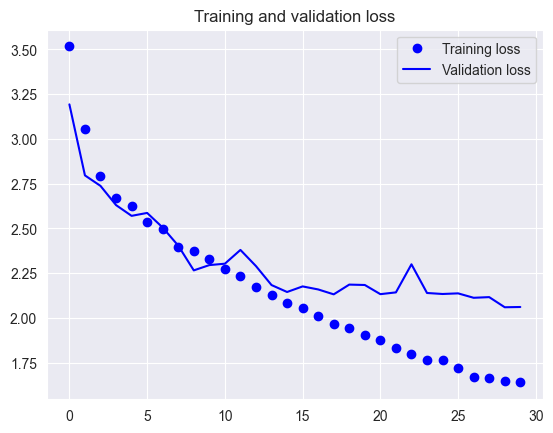

In [75]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## Prediction

In [76]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step
The first 5 predictions: ['Basal Cell Carcinoma', 'Melanoma', 'Squamous Cell Carcinoma', 'Nevus', 'Nevus']


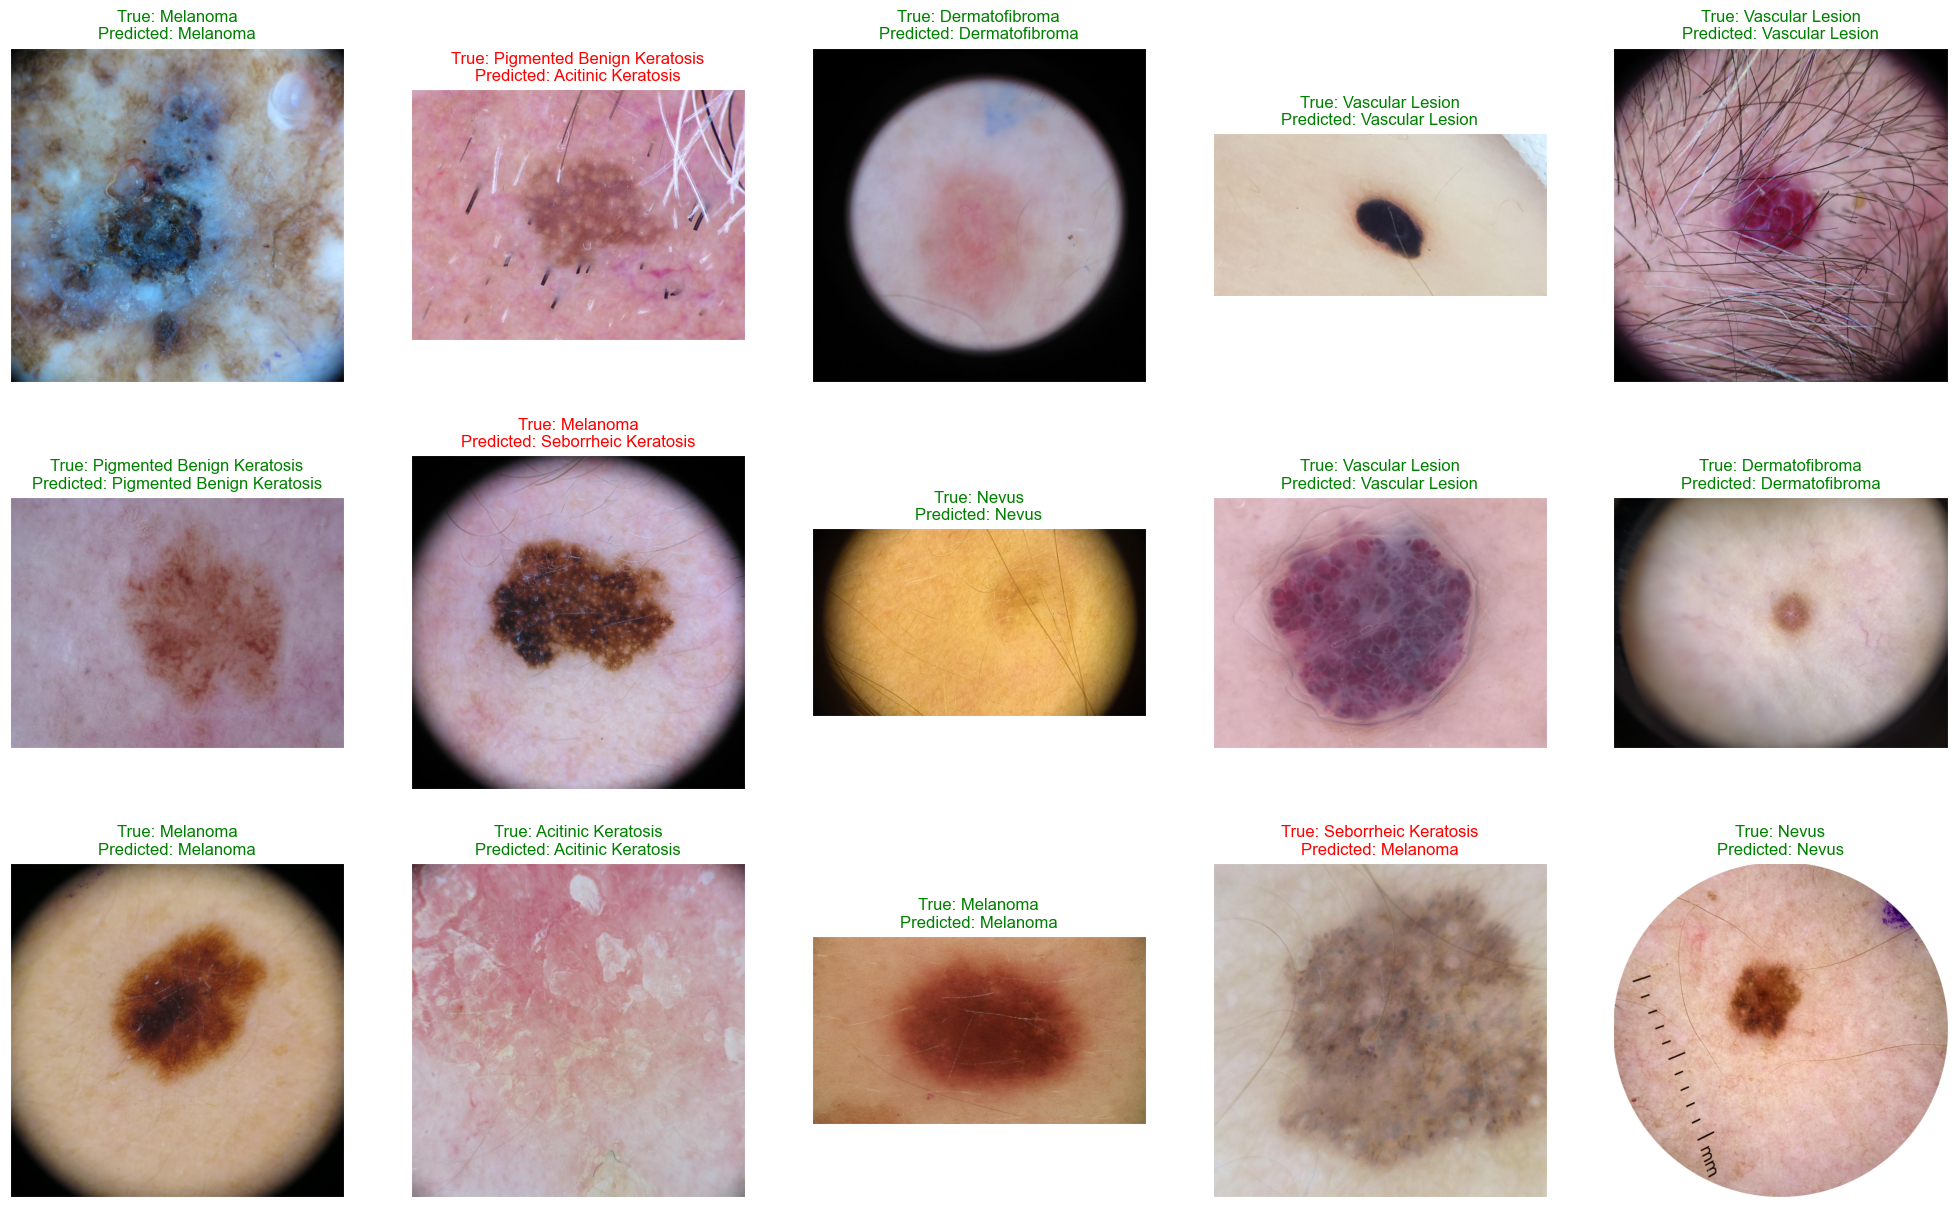

<Figure size 640x480 with 0 Axes>

In [77]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## Classification Report

In [78]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred, digits=4))

                            precision    recall  f1-score   support

        Acitinic Keratosis     0.5738    0.6667    0.6167       105
      Basal Cell Carcinoma     0.4497    0.6442    0.5296       104
            Dermatofibroma     0.7385    0.6234    0.6761        77
                  Melanoma     0.8143    0.5044    0.6230       113
                     Nevus     0.7732    0.7653    0.7692        98
Pigmented Benign Keratosis     0.7946    0.8812    0.8357       101
      Seborrheic Keratosis     0.4948    0.5393    0.5161        89
   Squamous Cell Carcinoma     0.6667    0.5128    0.5797        78
           Vascular Lesion     0.8400    0.7368    0.7850        57

                  accuracy                         0.6521       822
                 macro avg     0.6828    0.6527    0.6590       822
              weighted avg     0.6762    0.6521    0.6545       822



## Saving Model

In [79]:
# Save the entire model
model.save('skin_disease_model.keras')